In [53]:
import pandas as pd
import requests
import json
from tqdm import tqdm
import ollama
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

In [58]:
prompt="""
Réponds moi dans le format suivant :

Rémunérations=Oui/Non
Conditions de travail=Oui/Non
Emploi-licenciement=Oui/Non
Temps de travail=Oui/Non
Autres revendications=Oui/Non
Article de grève=Oui/Non


Catégories liées aux motifs de revendication des grèves :
* Rémunérations : revendications salariales, primes
* Conditions de travail : dégradations des conditions de travail, demande d'amélioration des conditions de travail
* Emploi-liceneciement : fermeture de site, de postes, demande de postes supplémentaires
* Temps de travail : réduction du temps de travail, contre l'augmentation du temps de travail
* Autres revendications : réforme des retraites, autres réformes ou toute chose qui ne concerne pas ce qui a été cité precedemment


 Texte : 
"""

In [64]:
prompt="""
Réponds moi dans le format suivant :

Lieu de grève:
Ville de grève : 
Nom de l'entreprise, le cas échéant :
Date de début de grève :
Date de fin de grève :
Durée de grève :
Pays de grève : 
Motif_revendication: [Rémunérations, Conditions de travail, Emploi-licenciement, Temps de travail,Autres revendications] 
Nombre ou proportion de gréviste:
Périmetre de grève (local, sectoriel, interprofessionnelle) :



Catégories liées aux motifs de revendication des grèves :
* Rémunérations : revendications salariales, primes
* Conditions de travail : dégradations des conditions de travail, demande d'amélioration des conditions de travail
* Emploi-liceneciement : fermeture de site, de postes, demande de postes supplémentaires
* Temps de travail : réduction du temps de travail, contre l'augmentation du temps de travail
* Autres revendications : réforme des retraites, autres réformes



Texte : 
"""


In [40]:
df_motiflast = pd.read_csv('/home/onyxia/work/Ollama/data/motiflast.csv')
df=df_motiflast[['text',"sentiment"]]
df.shape

(141, 2)

In [33]:
df_train, df_test = train_test_split(df, test_size=0.7, random_state=0)
df=df_train

In [67]:
list_of_df=[]

for index, row in df.iterrows():
    prompt2 = prompt + row.text
    response = requests.post("http://127.0.0.1:11434/api/generate", json={"model": "llama3.1", "prompt": str(prompt2) })
    response.raise_for_status()
    response_text=''.join([json.loads(line)['response'] for line in response.text.splitlines()])
    print(response_text)
    print("-----------")
    rem,ct,empl,tt,autres,greve=0,0,0,0,0,0
    if "Rémunérations=Oui" in response_text:
        rem=1
    if "Conditions de travail=Oui" in response_text:
        ct=1
    if "Emploi-licenciement=Oui" in response_text:
        empl=1
    if "Temps de travail=Oui" in response_text:
        tt=1
    if "Autres revendications=Oui" in response_text:
        autres=1

    if "Article de grève=Oui" in response_text:
        greve=1

    #print(greve," : ",rem,ct,empl,tt,autres,response_text)
    list_of_df.append(
        pd.DataFrame(
    {
     "text":[row.text],
     "sentiment":[row.sentiment],
     "greve":[greve],
     "rem":[rem],
     "ct":[ct],
     "empl":[empl],
     "tt":[tt],
     "autres":[autres],
    }
     )
    )

df_inference=pd.concat(list_of_df,ignore_index=True)

Voici les informations que tu as demandé :

Lieu de grève: Site de production du quotidien
Ville de grève : Non spécifiée
Nom de l'entreprise, le cas échéant : La Croix
Date de début de grève : Hier (sans date précise)
Date de fin de grève : Pas mentionnée
Durée de grève : En cours
Pays de grève : France
Motif_revendication: Conditions de travail et Emploi-licenciement
Nombre ou proportion de gréviste: Non spécifié
Périmetre de grève (local, sectoriel, interprofessionnelle) : Local

Catégories liées aux motifs de revendication des grèves :
* Rémunérations : non
* Conditions de travail : oui
* Emploi-liceneciement : oui
* Temps de travail : non
* Autres revendications : non
-----------
Voici les informations dans le format demandé :

Lieu de grève : Seine-Saint-Denis
Ville de grève : Non spécifié ( multiples villes du département)
Nom de l'entreprise, le cas échéant : Collèges (enseignement public)
Date de début de grève : Mardi 21 novembre
Date de fin de grève : Non spécifiée
Durée de 

KeyboardInterrupt: 

In [42]:
df_inference.to_parquet("resultats_llama3.1.parquet")

In [60]:
df_dummies=pd.merge(pd.get_dummies(df["sentiment"]).astype(int),df,how="inner",left_index=True,right_index=True)

In [61]:
df_merge=pd.merge(df_inference,df_dummies,how="inner",left_on="text",right_on="text")
df_merge.head()

,text,sentiment_x,greve,rem,ct,empl,tt,autres,Autres,Conditions de travail,Emploi-licenciement,Rémunérations,Temps de travail,sentiment_y
0,« La Croix » absent des kiosques depuis hier L...,Emploi-licenciement,0,0,1,1,0,0,0,0,1,0,0,Emploi-licenciement
1,Seine-Saint-Denis : les agents techniques des ...,Conditions de travail,1,0,1,1,0,0,0,1,0,0,0,Conditions de travail
2,Trafic perturbé sur le RER E demain Le trafic ...,Conditions de travail,1,0,1,1,0,0,0,1,0,0,0,Conditions de travail
3,Électricité : négociations salariales chez RTE...,Rémunérations,1,1,0,0,0,0,0,0,0,1,0,Rémunérations
4,EasyJet:appel à la grève Le syndicat Unac des ...,Rémunérations,0,1,0,0,0,0,0,0,0,1,0,Rémunérations


In [62]:
import numpy as np
from sklearn.metrics import confusion_matrix


def show_cm(yt,yp):
    y_true = yt
    y_pred = yp
    
    cm = confusion_matrix(y_true, y_pred)    
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
    
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    report = classification_report(y_true, y_pred)
    
    print(f'Accuracy: {accuracy}')
    print(f'Precision (macro): {precision}')
    print(f'Recall (macro): {recall}')
    print(f'F1 Score (macro): {f1}')
    print("-"*10)
    print('Classification Report:')
    print(report)

    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
    # Ajouter des labels
    plt.xlabel('Prédictions')
    plt.ylabel('Réel')
    plt.title('Matrice de Confusion')
    
    
        
    #image_path = os.path.join(save_dir, 'Confusion Matrix')
    
    plt.savefig('Confusion Matrix', dpi=300, bbox_inches='tight')
    
    plt.show()

Accuracy: 0.6950354609929078
Precision (macro): 0.6938405797101449
Recall (macro): 0.6966108615761535
F1 Score (macro): 0.6934937566351549
----------
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.68      0.72        79
           1       0.64      0.71      0.67        62

    accuracy                           0.70       141
   macro avg       0.69      0.70      0.69       141
weighted avg       0.70      0.70      0.70       141



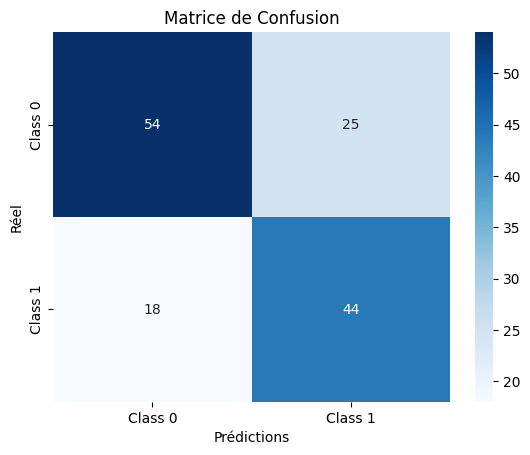

In [63]:
#show_cm(df_merge["Rémunérations"],df_merge.rem)
#show_cm(df_merge["Conditions de travail"],df_merge.ct)
#show_cm(df_merge["Emploi-licenciement"],df_merge.empl)
#show_cm(df_merge["Temps de travail"],df_merge.tt)
show_cm(df_merge["Autres"],df_merge.autres)



In [47]:
import numpy as np
from sklearn.metrics import multilabel_confusion_matrix

# Example of true labels and predicted labels
y_true = np.array(df_merge[["Rémunérations","Conditions de travail","Emploi-licenciement","Temps de travail","Autres"]])
y_pred = np.array(df_merge[["rem","ct","empl","tt","autres"]])

# Compute the confusion matrix
confusion_matrices = multilabel_confusion_matrix(y_true, y_pred)

# Print the confusion matrix for each label
for idx, cm in enumerate(confusion_matrices):
    print(f"Confusion Matrix for label {idx}:")
    print(cm)
    print("\n")


Confusion Matrix for label 0:
[[90 18]
 [13 20]]


Confusion Matrix for label 1:
[[50 58]
 [ 7 26]]


Confusion Matrix for label 2:
[[98 32]
 [ 2  9]]


Confusion Matrix for label 3:
[[134   5]
 [  0   2]]


Confusion Matrix for label 4:
[[54 25]
 [18 44]]




In [30]:
df.shape

(141, 2)